# Companion Notebook - 7.2 Inspecting and monitoring DL models 
# using Keras callbacks & TensorBoard
## updated for TensorFlow & Keras 2.x
## Chap 7 « Advanced Deep-learning best practices »
## « Deep Learning with Python » book by François Chollet

This notebook contains the code samples found in Chapter 7 of «Deep Learning with Python». Note that the original text features far more content, in particular further explanations and figures. In this companion Notebook, you will find source code along with small corrections and some additions by Claude COULOMBE - PhD - Montréal.

In [1]:
# sudo pip3 install --ignore-installed --upgrade tensorflow
import keras
print("Keras version:",keras.__version__)
import tensorflow as tf
print("TensorFlow version:",tf.__version__)


Using TensorFlow backend.


2.3.1
2.2.0


## 7.2. Inspecting and monitoring DL models using Keras call-backs and TensorBoard 

In this section, we’ll review ways to gain greater access to and control over what goes on inside your model during training. Launching a training run on a large dataset for tens of epochs using model.fit() or model.fit_generator() can be a bit like launching a paper airplane: past the initial impulse, you don’t have any control over its trajectory or its landing spot. If you want to avoid bad outcomes (and thus wasted paper airplanes), it’s smarter to use not a paper plane, but a drone that can sense its environment, send data back to its operator, and automatically make steering decisions based on its current state. The techniques we present here will transform the call to model.fit() from a paper airplane into a smart, autonomous drone that can self-introspect and dynamically take action. 

### 7.2.1. Using callbacks to act on a model during training 

When you’re training a model, there are many things you can’t predict from the start. In particular, you can’t tell how many epochs will be needed to get to an optimal validation loss. The examples so far have adopted the strategy of training for enough epochs that you begin overfitting, using the first run to figure out the proper number of epochs to train for, and then finally launching a new training run from scratch using this optimal number. Of course, this approach is wasteful. 

A much better way to handle this is to stop training when you measure that the validation loss in no longer improving. This can be achieved using a Keras callback. A callback is an object (a class instance implementing specific methods) that is passed to the model in the call to fit and that is called by the model at various points during training. It has access to all the available data about the state of the model and its performance, and it can take action: interrupt training, save a model, load a different weight set, or otherwise alter the state of the model.

Here are some examples of ways you can use callbacks: 

* **Model checkpointing** — Saving the current weights of the model at different points during training. 
* **Early stopping** — Interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training). 
* **Dynamically adjusting the value of certain parameters during training** — Such as the learning rate of the optimizer. 
* **Logging / Visualizing training and validation metrics during training** or visualizing the representations learned by the model as they’re updated — The Keras progress bar that you’re familiar with is a callback!

The keras.callbacks module includes a number of built-in callbacks (this is not an exhaustive list):

https://keras.io/callbacks/

* keras.callbacks.ModelCheckpoint
* keras.callbacks.EarlyStopping
* keras.callbacks.LearningRateScheduler
* keras.callbacks.ReduceLROnPlateau
* keras.callbacks.CSVLogger

### The ModelCheckpoint and EarlyStopping callbacks

You can use the `EarlyStopping` callback to interrupt training once a target metric being monitored has stopped improving for a fixed number of epochs. For instance, this callback allows you to interrupt training as soon as you start overfitting, thus avoiding having to retrain your model for a smaller number of epochs. This callback is typically used in combination with `ModelCheckpoint`, which lets you continually save the model during training (and, optionally, save only the current best model so far: the version of the model that achieved the best performance at the end of an epoch)

```Python

import keras

# Callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    # Interrupts training when improvement stops
    keras.callbacks.EarlyStopping(
        # Monitors the model’s validation accuracy
        monitor='val_accuracy',
        # Interrupts training when accuracy has stopped 
        # improving for more than one epoch (that is, two epochs)
        patience=1,
    ),
    # Saves the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
        # Path to the destination model file
        filepath='my_model_callback.h5',
        # These two arguments mean you won’t overwrite the model file 
        # unless val_loss has improved, 
        monitor='val_loss',
        # which allows you to keep the best model seen during training
        save_best_only=True,
    )
]

# You monitor accuracy, so it should be part of the model’s metrics.
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Note that because the callback will monitor validation loss and validation accuracy,
# you need to pass validation_data to the call to fit.
model.fit(x, y,
          epochs=10,
          batch_size=32,
          callbacks=callbacks_list,
          validation_data=(x_val, y_val)
         )
```

### Train a CNN model using the Functional API and the MNIST data
### with EarlyStopping and ModelCheckpoint callbacks

Inspired by: 
https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [2]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def cnn_layers(inputs):
    x = layers.Conv2D(32, (3, 3),
                      activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes,
                               activation='softmax',
                               name='x_train_out')(x)
    return predictions

model_input = layers.Input(shape=(28, 28, 1), dtype='float32', name='images')
model_output = cnn_layers(model_input)
model = keras.models.Model(inputs=model_input, outputs=model_output)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8197

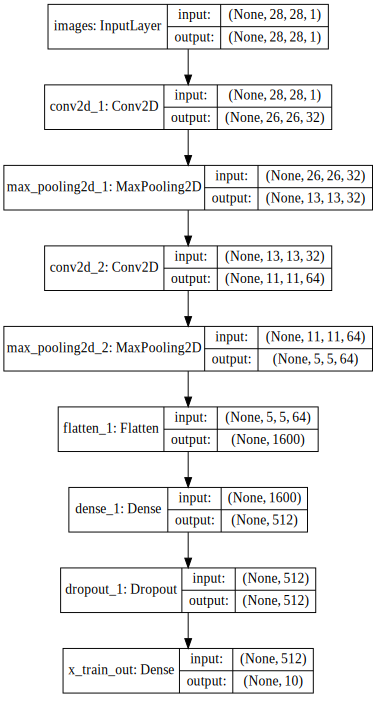

In [3]:
model.summary()

# https://stackoverflow.com/questions/51452569/how-to-resize-rescale-a-svg-graphic-in-an-ipython-jupyter-notebook/51452570#51452570
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=70).create(prog='dot', format='svg'))


#### Training the model

In [4]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [
    # Interrupts training when improvement stops
    keras.callbacks.EarlyStopping(
        # Monitors the model’s validation accuracy
        monitor='val_accuracy',
        # Interrupts training when accuracy has stopped 
        # improving for more than one epoch (that is, two epochs)
        patience=1,
    ),
    # Saves the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
        # Path to the destination model file
        filepath='my_model_callback.h5',
        # These two arguments mean you won’t overwrite the model file 
        # unless val_loss has improved, 
        monitor='val_loss',
        # which allows you to keep the best model seen during training
        save_best_only=True,
    )
]

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list,
                    # C.COULOMBE, in order to keep a test dataset
                    # just create a validation dataset by splitting
                    # the training dataset
                    validation_split=0.2
#                     validation_data=(x_test, y_test)
                   )


Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 39s 809us/step - loss: 0.2747 - accuracy: 0.9134 - val_loss: 0.0788 - val_accuracy: 0.9780
Epoch 2/12
48000/48000 [==============================] - 36s 758us/step - loss: 0.0749 - accuracy: 0.9766 - val_loss: 0.0506 - val_accuracy: 0.9856
Epoch 3/12
48000/48000 [==============================] - 44s 907us/step - loss: 0.0518 - accuracy: 0.9839 - val_loss: 0.0412 - val_accuracy: 0.9878
Epoch 4/12
48000/48000 [==============================] - 33s 690us/step - loss: 0.0412 - accuracy: 0.9871 - val_loss: 0.0414 - val_accuracy: 0.9884
Epoch 5/12
48000/48000 [==============================] - 34s 710us/step - loss: 0.0339 - accuracy: 0.9896 - val_loss: 0.0388 - val_accuracy: 0.9901
Epoch 6/12
48000/48000 [==============================] - 44s 916us/step - loss: 0.0283 - accuracy: 0.9914 - val_loss: 0.0389 - val_accuracy: 0.9890


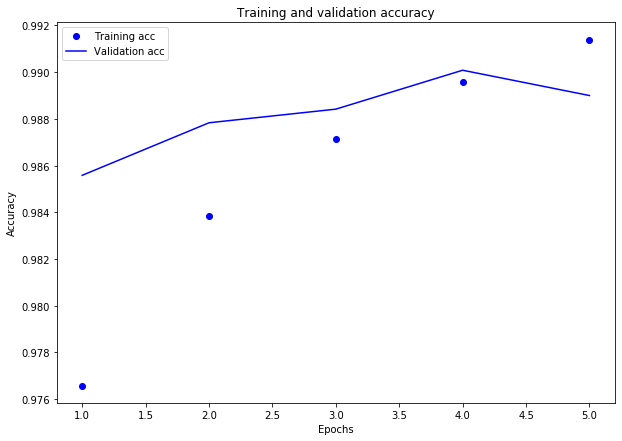

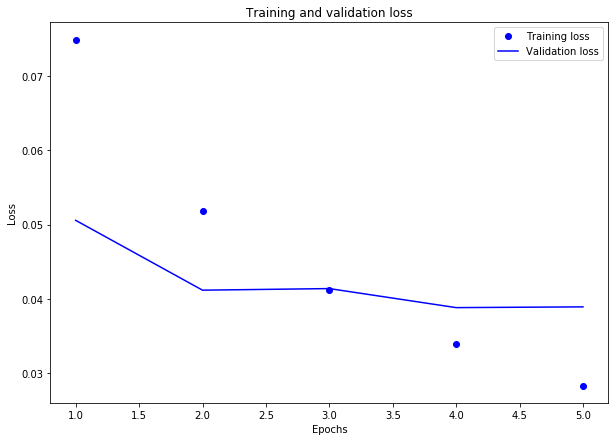

In [5]:
import matplotlib.pyplot as plt

acc = history.history['accuracy'][1:]
val_acc = history.history['val_accuracy'][1:]
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

# epochs = range(len(acc))
epochs = range(1,len(acc)+1)

plt.figure(figsize=(10,7))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10,7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [6]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.02771381025166338
Test accuracy: 0.9912999868392944


### The ReduceLROnPlateau callback

You can use this callback to reduce the learning rate when the validation loss has stopped improving. Reducing or increasing the learning rate in case of a loss plateau is is an effective strategy to get out of local minima during training. The following example uses the ReduceLROnPlateau callback:

```Python
callbacks_list = [ 
    keras.callbacks.ReduceLROnPlateau(
        # Monitors the model’s validation loss
        monitor='val_loss',
        # Divides the learning rate by 10 when triggered
        factor=0.1,
        # The callback is triggered after the validation loss 
        # has stopped improving for 10 epochs.
        patience=10,
    ) 
] 

model.fit(x, y,
    epochs=10,
    batch_size=32,
    callbacks=callbacks_list,
    validation_data=(x_val, y_val)
)  
```

### Train a CNN model using the Functional API and the MNIST data
### with ReduceLROnPlateau callback

Inspired by: 
https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [7]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def cnn_layers(inputs):
    x = layers.Conv2D(32, (3, 3),
                      activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes,
                               activation='softmax',
                               name='x_train_out')(x)
    return predictions

model_input = layers.Input(shape=(28, 28, 1), dtype='float32', name='images')
model_output = cnn_layers(model_input)
model = keras.models.Model(inputs=model_input, outputs=model_output)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               8197

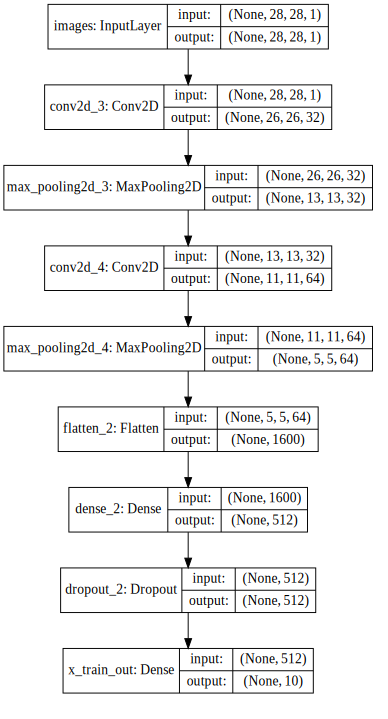

In [9]:
model.summary()

# https://stackoverflow.com/questions/51452569/how-to-resize-rescale-a-svg-graphic-in-an-ipython-jupyter-notebook/51452570#51452570
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=70).create(prog='dot', format='svg'))


#### Training the model

In [10]:
# Callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [ 
    keras.callbacks.ReduceLROnPlateau(
        # Monitors the model’s validation loss
        monitor='val_loss',
        # Divides the learning rate by 10 when triggered
        factor=0.1,
        # The callback is triggered after the validation loss 
        # has stopped improving for 1 epochs.
        patience=1,
    ) 
] 

history = model.fit(x_train, y_train,
                    # C.COULOMBE More epochs in order to 
                    # get more learning rate changes
                    epochs=15,
                    batch_size=32,
                    verbose=1,
                    callbacks=callbacks_list,
                    # C.COULOMBE, in order to keep a test dataset
                    # just create a validation dataset by splitting
                    # the training dataset
                    validation_split=0.2
#                     validation_data=(x_test, y_test)
                   )


Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 114s 2ms/step - loss: 0.1647 - accuracy: 0.9481 - val_loss: 0.0532 - val_accuracy: 0.9847
Epoch 2/15
48000/48000 [==============================] - 125s 3ms/step - loss: 0.0557 - accuracy: 0.9827 - val_loss: 0.0540 - val_accuracy: 0.9830
Epoch 3/15
48000/48000 [==============================] - 146s 3ms/step - loss: 0.0347 - accuracy: 0.9893 - val_loss: 0.0367 - val_accuracy: 0.9894
Epoch 4/15
48000/48000 [==============================] - 142s 3ms/step - loss: 0.0299 - accuracy: 0.9910 - val_loss: 0.0347 - val_accuracy: 0.9903
Epoch 5/15
48000/48000 [==============================] - 147s 3ms/step - loss: 0.0300 - accuracy: 0.9906 - val_loss: 0.0350 - val_accuracy: 0.9903
Epoch 6/15
48000/48000 [==============================] - 147s 3ms/step - loss: 0.0265 - accuracy: 0.9920 - val_loss: 0.0345 - val_accuracy: 0.9905
Epoch 7/15
48000/48000 [==============================] - 141s

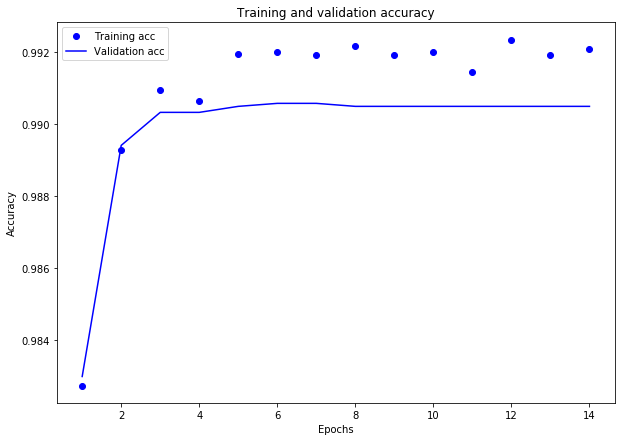

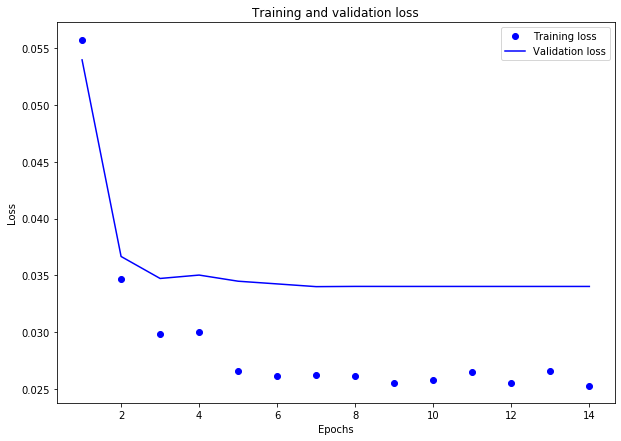

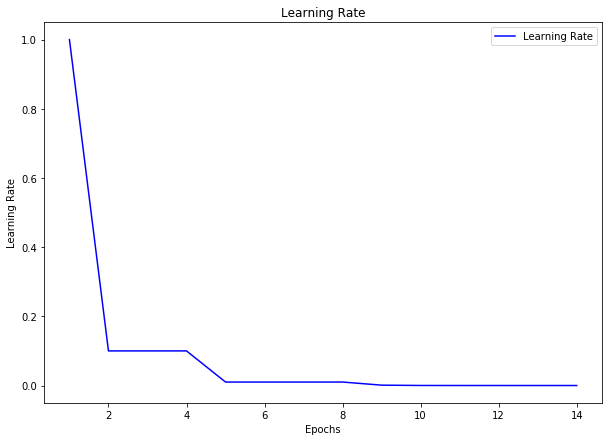

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy'][1:]
val_acc = history.history['val_accuracy'][1:]
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]
lr = history.history['lr'][1:]

# epochs = range(len(acc))
epochs = range(1,len(acc)+1)

plt.figure(figsize=(10,7))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10,7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(10,7))

plt.plot(epochs, lr, 'b', label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

plt.show()

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.02493110312195495
Test accuracy: 0.9905999898910522


### Writing your own callback

If you need to take a specific action during training that isn’t covered by one of the built-in callbacks, you can write your own callback. Callbacks are implemented by subclassing the class `keras.callbacks.Callback`. You can then implement any number of the following transparently named methods, which are called at various points during training: 

```Python
# Called at the start of every epoch
on_epoch_begin
# Called at the end of every epoch
on_epoch_end
# Called right before processing each batch
on_batch_begin
# Called right after processing each batch
on_batch_end
# Called at the start of training 
on_train_begin
# Called at the end of training
on_train_end  
```

These methods all are called with a logs argument, which is a dictionary containing information about the previous batch, epoch, or training run: training and validation metrics, and so on. Additionally, the callback has access to the following attributes: 

* `self.model` — The model instance from which the callback is being called 
* `self.validation_data` — The value of what was passed to fit as validation data 

Here’s a simple example of a custom callback that saves to disk (as Numpy arrays) the activations (weights ?) of every layer of the model at the end of every epoch, computed on the first sample of the validation set: 

```Python
import keras
import numpy as np
from keras import layers

class ActivationLogger(keras.callbacks.Callback):

    def set_model(self, model):
        # Called by the parent model before training, 
        # to inform the callback of what model will be calling it
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        # Model instance that returns the activations of every layer
        self.activations_model = keras.models.Model(model.input,layer_outputs)
    
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
        # Obtains the first input sample of the validation data
        validation_sample = self.validation_data[0][0:1]
        activations = self.activations_model.predict(validation_sample)
        # Saves arrays to disk
        f = open('activations_at_epoch_' + str(epoch) + '.npz', 'wb')
        np.savez(f,*activations)
        f.close() 
```

This is all you need to know about callbacks—the rest is technical details, which you can easily look up. Now you’re equipped to perform any sort of logging or preprogrammed intervention on a Keras model during training.

### Train a CNN model using the Functional API and the MNIST data
### with custom ActivationLogger callback

Inspired by: 
https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [15]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import tensorflow as tf

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def cnn_layers(inputs):
    x = layers.Conv2D(32, (3, 3),
                      activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes,
                               activation='softmax',
                               name='x_train_out')(x)
    return predictions

model_input = layers.Input(shape=(28, 28, 1), dtype='float32', name='images')
model_output = cnn_layers(model_input)
model = keras.models.Model(inputs=model_input, outputs=model_output)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               8197

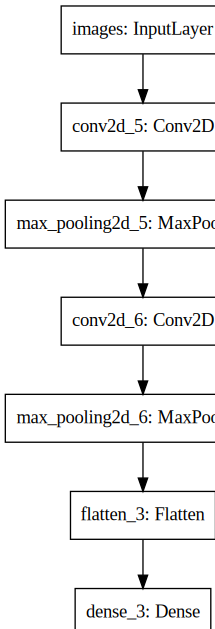

In [16]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### Training the model

In [18]:
class ActivationLogger(keras.callbacks.Callback):

    def set_model(self, model):
        # Called by the parent model before training, 
        # to inform the callback of what model will be calling it
        self.model = model
        # Here the model has 9 layers
        layer_outputs = [layer.output for layer in model.layers]
        # Model instance that returns the activations of every layer
        #  self.activations_model = keras.models.Model(inputs=model.inputs[0],outputs=layer_outputs)
        self.activations_model = keras.models.Model(model.input,layer_outputs)

    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
        # Obtains the first input sample of the validation data
        validation_sample_x = self.validation_data[0][0:1]
        validation_sample_y = self.validation_data[1]
        # predict(self, x, batch_size=None, verbose=0, steps=None)
        # x: The input data, as a Numpy array (or list of Numpy arrays if the model has multiple outputs).
        activations = self.activations_model.predict(validation_sample_x)
        # Saves arrays to disk
        f = open('activations_at_epoch_' + str(epoch) + '.npz', 'wb')
        # Since we have several arrays of different dimensions, we expand the arguments:
        np.savez(f,*activations)
        f.close()
        
# Callbacks are passed to the model via the callbacks argument in fit, 
# which takes a list of callbacks. You can pass any number of callbacks.
callbacks_list = [ 
    ActivationLogger() 
] 

history = model.fit(x_train, y_train,
                    epochs=12,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=callbacks_list,
                    # C.COULOMBE, in order to keep a test dataset
                    # just create a validation dataset by splitting
                    # the training dataset
                    validation_split=0.2
                   )

# # Managing our own validation dataset
# # But it seems not working ???
# from sklearn.model_selection import train_test_split
# x_train_splitted, x_test_splitted, y_train_splitted, y_test_splitted = train_test_split(x_train, y_train, test_size=0.20)
    
# history = model.fit(x_train_splitted, y_train_splitted,
#                     epochs=12,
#                     batch_size=batch_size,
#                     verbose=1,
#                     callbacks=callbacks_list,
#                     # C.COULOMBE, in order to keep a test dataset
#                     # just create a validation dataset by splitting
#                     # the training dataset
#                     validation_data=(x_test_splitted,y_test_splitted)
#                    )

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 40s 834us/step - loss: 0.0464 - accuracy: 0.9854 - val_loss: 0.0404 - val_accuracy: 0.9882
Epoch 2/12
48000/48000 [==============================] - 51s 1ms/step - loss: 0.0377 - accuracy: 0.9886 - val_loss: 0.0402 - val_accuracy: 0.9883
Epoch 3/12
48000/48000 [==============================] - 44s 912us/step - loss: 0.0323 - accuracy: 0.9901 - val_loss: 0.0361 - val_accuracy: 0.9899
Epoch 4/12
48000/48000 [==============================] - 44s 919us/step - loss: 0.0267 - accuracy: 0.9917 - val_loss: 0.0352 - val_accuracy: 0.9897
Epoch 5/12
48000/48000 [==============================] - 50s 1ms/step - loss: 0.0232 - accuracy: 0.9926 - val_loss: 0.0327 - val_accuracy: 0.9909
Epoch 6/12
48000/48000 [==============================] - 52s 1ms/step - loss: 0.0201 - accuracy: 0.9936 - val_loss: 0.0321 - val_accuracy: 0.9907
Epoch 7/12
48000/48000 [==============================] - 50s 

#### Recover the layers activation weights

In [19]:
# For example, recover the arrays of weights for the last epoch 12 => 11 
# and the last layer 9 => 8
last_epoch_activations = np.load('activations_at_epoch_11.npz')
activations = [last_epoch_activations[key] for key in last_epoch_activations]
print(len(activations))
print(activations[8])


9
[[8.1528710e-14 2.2341968e-09 2.0320469e-11 2.7226197e-15 1.0000000e+00
  1.8543253e-12 4.3287062e-12 4.7701313e-08 4.8201977e-15 1.8084691e-13]]


    validation_split=0.2 => max at position 4
    9
    [[7.2092994e-09 1.1835451e-06 6.5328450e-08 2.8607983e-10 9.9999261e-01
      1.7434639e-08 1.3809360e-08 6.1131664e-06 3.6436916e-08 7.9334370e-09]]
    
    managed validation dataset => max at position 2 or 9
    9
    [[1.3574504e-05 9.0395837e-14 9.9998295e-01 3.4304901e-06 1.5983891e-11
      2.8917981e-11 4.4910222e-09 6.6057880e-13 1.4223739e-08 3.7631470e-13]]

This is all you need to know about callbacks—the rest is technical details, which you can easily look up. Now you’re equipped to perform any sort of logging or preprogrammed intervention on a Keras model during training.

### 7.2.2. Introduction to TensorBoard: the TensorFlow visualization framework 

To do good research or develop good models, you need rich, frequent feedback about what’s going on inside your models during your experiments. That’s the point of running experiments: to get information about how well a model performs—as much information as possible. Making progress is an iterative process, or loop: you start with an idea and express it as an experiment, attempting to validate or invalidate your idea. You run this experiment and process the information it generates. This inspires your next idea. The more iterations of this loop you’re able to run, the more refined and powerful your ideas become. Keras helps you go from idea to experiment in the least possible time, and fast GPUs can help you get from experiment to result as quickly as possible. 

But what about processing the experiment results? That’s where TensorBoard comes in.

This section introduces TensorBoard, a browser-based visualization tool that comes packaged with TensorFlow. Note that it’s only available for Keras models when you’re using Keras with the TensorFlow backend. 

The key purpose of TensorBoard is to help you visually monitor everything that goes on inside your model during training. If you’re monitoring more information than just the model’s final loss, you can develop a clearer vision of what the model does and doesn’t do, and you can make progress more quickly. TensorBoard gives you access to several neat features, all in your browser: 

* Visually monitoring metrics during training Visualizing your model architecture
* Visualizing your model architecture
* Visualizing histograms of activations and gradients 
* Exploring embeddings in 3D 

Let’s demonstrate these features on a simple example. You’ll train a 1D convnet on the IMDB sentiment-analysis task. 

The model is similar to the one you saw in the last section of chapter 6. You’ll consider only the top 2,000 words in the IMDB vocabulary, to make visualizing word embeddings more tractable. 

#### Text-classification model to use with TensorBoard

In [20]:
import keras 
from keras import layers 
from keras.datasets import imdb 
from keras.preprocessing import sequence 

# Number of words to consider as features
max_features = 2000
# Cuts off texts after this number of words (among max_features most common words)
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) 
x_train = sequence.pad_sequences(x_train, maxlen=max_len) 
x_test = sequence.pad_sequences(x_test, maxlen=max_len) 

model = keras.models.Sequential()
model.add(layers.Embedding(max_features,128,
                           input_length=max_len,
                           name='embedding'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

print("Code executed")


Code executed


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          256000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
________________________________________________

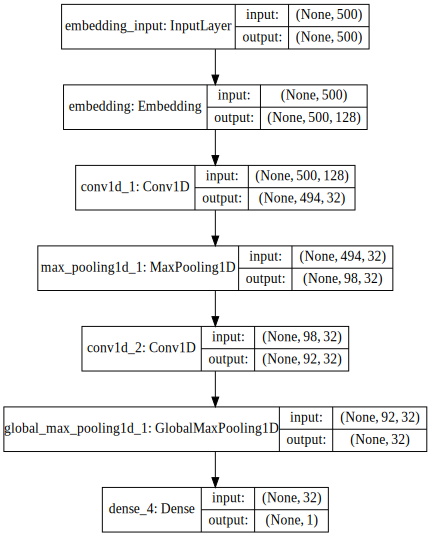

In [21]:
model.summary()

# https://stackoverflow.com/questions/51452569/how-to-resize-rescale-a-svg-graphic-in-an-ipython-jupyter-notebook/51452570#51452570
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=70).create(prog='dot', format='svg'))


Before you start using TensorBoard, you need to create a directory where you’ll store the log files it generates.

Creating a directory for TensorBoard log files

    > mkdir my_log_dir
    
Let’s launch the training with a TensorBoard callback instance. This callback will write log events to disk at the specified location.

#### Training the model with a TensorBoard callback

In [22]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.TensorBoard( 
                                # Log files will be written at this location.
                                log_dir='my_log_dir',
                                # Records activation histograms every 1 epoch
                                histogram_freq=1,
                                # Records embedding data every 1 epoch
                                embeddings_freq=1,
                               ) 
] 

history = model.fit(x_train, y_train,
                    epochs=4,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/callbacks/tensorboard_v2.py:102: UserWarning: The TensorBoard callback does not support embeddings display when using TensorFlow 2.0. Embeddings-related arguments are ignored.
  warnings.warn('The TensorBoard callback does not support '
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 71s 4ms/step - loss: 0.5840 - accuracy: 0.6834 - val_loss: 0.4153 - val_accuracy: 0.8284
Epoch 2/4
20000/20000 [==============================] - 71s 4ms/step - loss: 0.4107 - accuracy: 0.8243 - val_loss: 0.4359 - val_accuracy: 0.8142
Epoch 3/4
20000/20000 [==============================] - 66s 3ms/step - loss: 0.3632 - accuracy: 0.7819 - val_loss: 0.4383 - val_accuracy: 0.7804
Epoch 4/4
20000/20000 [==============================] - 78s 4ms/step - loss: 0.2936 - accuracy: 0.7526 - val_loss: 0.4992 - val_accuracy: 0.7078


#### Tensorboard

At this point, you can launch the TensorBoard server from the command line, instructing it to read the logs the callback is currently writing.

The tensorboard utility should have been automatically installed on your machine the moment you installed TensorFlow (for example, via pip): 

    > cd /Users/claudecoulombe/git/deep-learning-with-python-notebooks
    > tensorboard --logdir=my_log_dir 

##### Scalars
You can then browse to http://localhost:6006 and look at your model training (see figure 7.10). In addition to live graphs of the training and validation metrics,  

<center>Figure 7.10. TensorBoard: metrics monitoring</center>
<img src="images-old/TensorBoardMetricsMonitoring.png" width=600>

##### Histograms
you get access to the Histograms tab, where you can find pretty visualizations of histograms of activation values taken by your layers (see figure 7.11).

<center>Figure 7.11. TensorBoard: activation histograms</center>
<img src="images-old/TensorboardActivationsHistograms.png" width=600>

##### Graphs
The Graphs tab shows an interactive visualization of the graph of low-level TensorFlow operations underlying your Keras model (see figure 7.13). As you can see, there’s a lot more going on than you would expect. The model you just built may look simple when defined in Keras—a small stack of basic layers—but under the hood, you need to construct a fairly complex graph structure to make it work. A lot of it is related to the gradient-descent process. This complexity differential between what you see and what you’re manipulating is the key motivation for using Keras as your way of building models, instead of working with raw TensorFlow to define everything from scratch. Keras makes your workflow dramatically simpler. Figure 7.13. TensorBoard: TensorFlow graph visualization

<center>Figure 7.13. TensorBoard: TensorFlow graph visualization</center>
<img src="images-old/TensorboardComputeGraph.png" width=600>

##### Plot Model
Note that Keras also provides another, cleaner way to plot models as graphs of layers rather than graphs of TensorFlow operations: the utility keras.utils.plot_model. Using it requires that you’ve installed the Python pydot and pydot-ng libraries as well as the graphviz library. Let’s take a quick look: from keras.utils import plot_model plot_model(model, to_file='model.png') This creates the PNG image shown in figure 7.14.

    > sudo pip3 install pydot
    > sudo pip3 install pydot-ng
    > sudo pip3 install graphviz

### For Word embeddings and the embedding projector with Tensorflow and Keras 2 go to the tutorial 

https://www.tensorflow.org/tutorials/text/word_embeddings

It contains complete code to train word embeddings from scratch on a small dataset, and to visualize these embeddings using the Embedding Projector (shown in the image below).

You could also try this online version of the TensorFlow projector:

http://projector.tensorflow.org/


The Embeddings tab gives you a way to inspect the embedding locations and spatial relationships of the 2 000 (or 10,000) words in the input vocabulary, as learned by the initial Embedding layer. Because the embedding space is 128-dimensional, TensorBoard automatically reduces it to 2D or 3D using a dimensionality-reduction algorithm of your choice: either principal component analysis (PCA), Uor t-distributed stochastic neighbor embedding (t-SNE). 

In figure 7.12 below, in the point cloud, you can clearly see two clusters: words with a positive connotation and words with a negative connotation. The visualization makes it immediately obvious that embeddings trained jointly with a specific objective result in models that are completely specific to the underlying task—that’s the reason using pretrained generic word embeddings is rarely a good idea.

<center>Figure 7.12.a TensorBoard: interactive 3D word-embedding visualization - PCA</center>
<img src="images-old/TensorboardEmbeddingsPCA.png" width=600>

<center>Figure 7.12.b TensorBoard: interactive 3D word-embedding visualization - T-SNE</center>
<img src="images-old/TensorboardEmbeddingsTSNE.png" width=600>


#### A model plot as a graph of layers, generated with plot_model

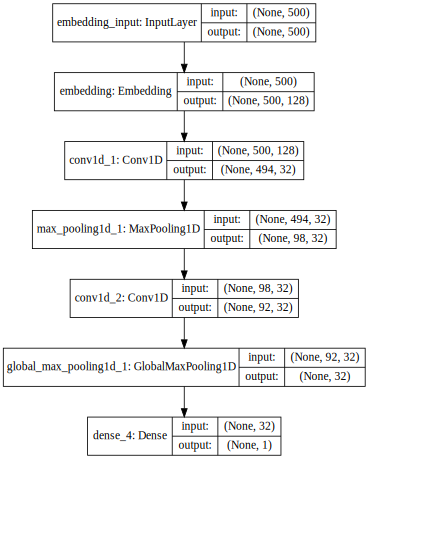

In [24]:
from keras.utils import plot_model 
plot_model(model, to_file='model.png')

# https://stackoverflow.com/questions/51452569/how-to-resize-rescale-a-svg-graphic-in-an-ipython-jupyter-notebook/51452570#51452570
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))


#### A model plot as a graph of layers with shape information

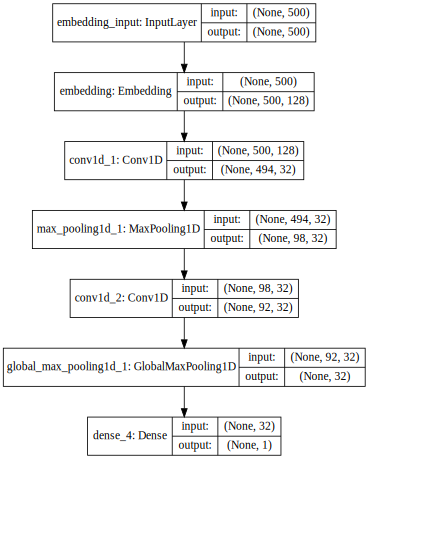

In [27]:
from keras.utils import plot_model 
plot_model(model, to_file='model.png')

# https://stackoverflow.com/questions/51452569/how-to-resize-rescale-a-svg-graphic-in-an-ipython-jupyter-notebook/51452570#51452570
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))
